In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from superfv import EulerSolver, plot_1d_slice, plot_timeseries, plot_spacetime
from superfv.initial_conditions import sedov
from teyssier.sedov import sedovana

In [2]:
N = 100
T = 0.8
gamma = 1.4

configs = {
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "ZS3": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        ZS=True,
        adaptive_dt=True,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "MM3": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        limiting_vars="actives",
        NAD=True,
        absolute_dmp=False,
        NAD_rtol=1e-1,
        NAD_atol=1e-8,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
}

sims = {}
for name, config in configs.items():
    print(f"Running {name}...")
    sim = EulerSolver(
        ic=partial(sedov, P0=1e-5, h=1 / N, gamma=gamma),
        gamma=gamma,
        bcx=("reflective", "free"),
        nx=N,
        **config,
    )

    try:
        if config.get("MUSCL", False):
            sim.musclhancock(T, allow_overshoot=True, snapshot_mode="every")
        else:
            sim.run(T, q_max=2, allow_overshoot=True, snapshot_mode="every")
    except Exception as e:
        print(f"Failed: {e}")
        continue

    sims[name] = sim

Running MUSCL-Hancock...
Step #307 @ t=8.02e-01 | dt=2.94e-03 | min(rho)=3.11e-02, min(P)=1.00e-05 | (done)                  
Running ZS3...
Step #312 @ t=8.02e-01 | dt=2.92e-03 | min(rho)=3.12e-02, min(P)=1.00e-05 | (done)                  
Running MM3...
Step #309 @ t=8.02e-01 | dt=2.93e-03 | min(rho)=3.10e-02, min(P)=1.00e-05 | (done)                  


In [3]:
# analytical solution for plotting
dim = 1
E0 = 1
rho0 = 1

r, d, u, P = sedovana(gamma, dim)

r *= (E0 / rho0) ** (1.0 / (dim + 2)) * T ** (2 / (dim + 2))
d *= rho0
u *= (E0 / rho0) ** (1.0 / (dim + 2)) * T ** (-dim / (dim + 2))
P *= (E0 / rho0) ** (2.0 / (dim + 2)) * T ** (-2 * dim / (dim + 2)) * rho0

chi0=np.float64(0.97306051566207)


(0.0, 1.0)

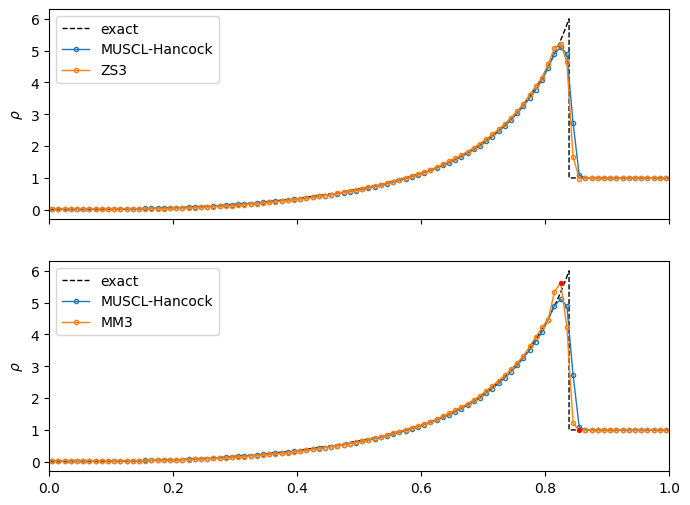

In [4]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey="row", figsize=(8, 6))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$\rho$")
axs[0].set_xlim(0, 1)

style = dict(linewidth=1, markersize=3)

axs[0].plot(r, d, color="k", linestyle="--", label="exact", **style)
axs[1].plot(r, d, color="k", linestyle="--", label="exact", **style)

for name, sim in sims.items():
    jlist = [0, 1] if name == "MUSCL-Hancock" else [1] if sim.MOOD else [0]
    for j in jlist:
        plot_1d_slice(
            sim,
            axs[j],
            "rho",
            trouble_marker="o" if sim.MOOD else None,
            label=name,
            marker="o",
            mfc="none",
            **style,
        )

axs[0].legend()
axs[1].legend()

axs[0].set_xlim(0, 1)

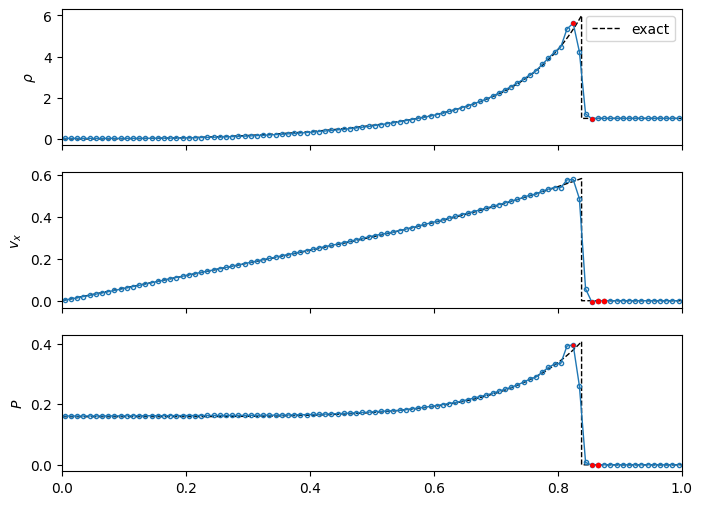

In [5]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey="row", figsize=(8, 6))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$v_x$")
axs[2].set_ylabel(r"$P$")
axs[0].set_xlim(0, 1)

style = dict(linewidth=1, markersize=3)

axs[0].plot(r, d, color="k", linestyle="--", label="exact", **style)
axs[1].plot(r, u, color="k", linestyle="--", label="exact", **style)
axs[2].plot(r, P, color="k", linestyle="--", label="exact", **style)

sim = sims["MM3"]

plot_1d_slice(sim, axs[0], "rho", marker="o", mfc="none", trouble_marker="o", **style)
plot_1d_slice(sim, axs[1], "vx", marker="o", mfc="none", trouble_marker="o", **style)
plot_1d_slice(sim, axs[2], "P", marker="o", mfc="none", trouble_marker="o", **style)


axs[0].legend()

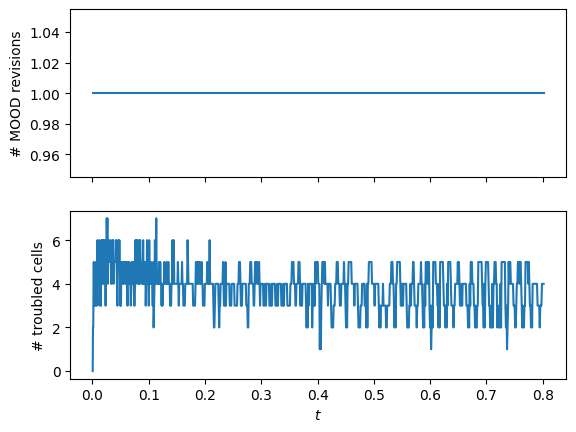

In [7]:
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].set_ylabel("# MOOD revisions")
axs[1].set_ylabel("# troubled cells")
axs[1].set_xlabel(r"$t$")

sim = sims["MM3"]

plot_timeseries(sim, axs[0], "nfine_MOOD_iters")
plot_timeseries(sim, axs[1], "nfine_troubles_vis_max")

(<matplotlib.image.AxesImage at 0x11fbd9220>,
 <matplotlib.colorbar.Colorbar at 0x11fbff860>)

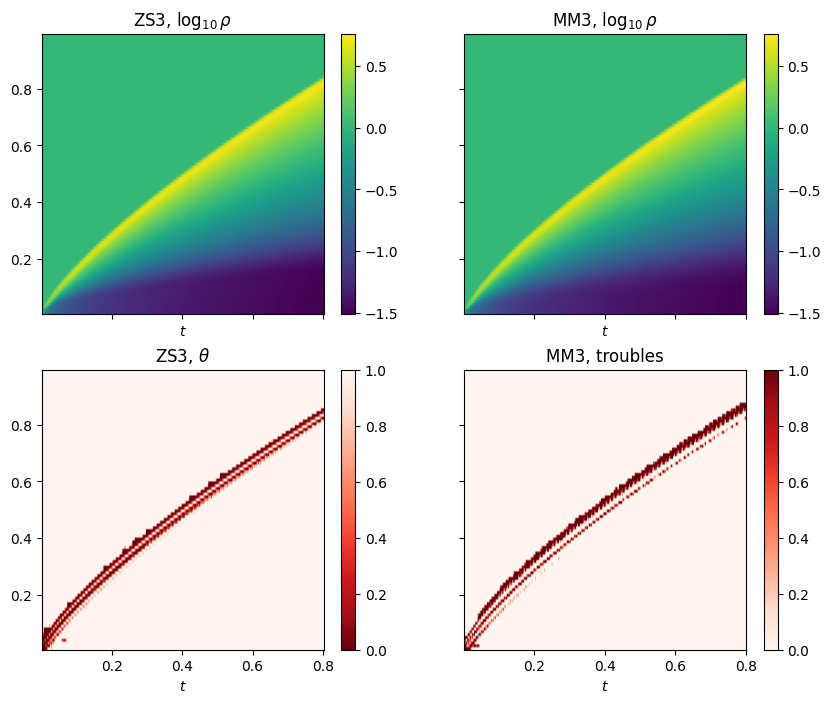

In [8]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
axs[0, 0].set_title(r"ZS3, $\log_{10} \rho$")
axs[0, 1].set_title(r"MM3, $\log_{10} \rho$")
axs[1, 0].set_title(r"ZS3, $\theta$")
axs[1, 1].set_title("MM3, troubles")

sim1 = sims["ZS3"]
sim2 = sims["MM3"]

vmin = min(
    np.log10(np.min(sim1.minisnapshots["min_rho"])),
    np.log10(np.max(sim2.minisnapshots["min_rho"])),
)
vmax = max(
    np.log10(np.max(sim1.minisnapshots["max_rho"])),
    np.log10(np.max(sim2.minisnapshots["max_rho"])),
)

rho_style = dict(
    cell_averaged=True, colorbar=True, func=lambda x: np.log10(x), vmin=vmin, vmax=vmax
)
plot_spacetime(sim1, axs[0, 0], "rho", **rho_style)
plot_spacetime(sim2, axs[0, 1], "rho", **rho_style)

plot_spacetime(sim1, axs[1, 0], "min", theta=True, colorbar=True, cmap="Reds_r")
plot_spacetime(sim2, axs[1, 1], "max", troubles=True, colorbar=True, cmap="Reds")